In [6]:
import heapq
import collections
import numpy as np
import matplotlib.pyplot as plt
import json
import PIL
import warnings
warnings.filterwarnings('ignore')

with open('char_map.json', 'r') as f:
    char_map = json.load(f)

char_map = {int(k): v for k, v in char_map.items()}
reverse_char_map = {v: k for k, v in char_map.items()}

## **Compression and Retrieval**

In [7]:
class TransmissionData():
    def __init__(self, img):
        self.img = img
        self.information = self.make_string_from_image()
        self.string = r'<l>'+str(img.shape[0])+r'<h>'+str(img.shape[1])+r'<s>'+self.make_string_from_image()+r'<e>'
        self.encoded_string, self.huffman_codes = self.huffman_encode()
        self.encoded_string_length = len(self.encoded_string)

    def make_string_from_image(self):
        image = self.img
        string = []
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                string.append(char_map[image[i][j]])
        return r''.join(string)
    
    def huffman_encode(self):
        text = self.string
        freq = collections.Counter(text)
        heap = [[weight, [char, r'']] for char, weight in freq.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            lo = heapq.heappop(heap)
            hi = heapq.heappop(heap)
            for pair in lo[1:]:
                pair[1] = '0' + pair[1]
            for pair in hi[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

        huffman_codes = dict(sorted(heapq.heappop(heap)[1:], key=lambda x: (len(x[-1]), x)))
        return ''.join(huffman_codes[char] for char in text), huffman_codes

    def show_image(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()


class RecievedData():
    def __init__(self, string, huffman_codes):

        self.string = string
        self.huffman_codes = huffman_codes
        self.decoded_string = self.huffman_decode()
        start = self.decoded_string.find(r'<s>')+3
        end = self.decoded_string.find(r'<e>')
        start_d = self.decoded_string.find(r'<l>')+3
        end_d = self.decoded_string.find(r'<h>')
        legth = int(self.decoded_string[start_d:end_d])
        height = int(self.decoded_string[end_d+3:end_d+5])
        self.dimension = (legth, height)
        self.decoded_string = self.decoded_string[start:end]
        self.img = self.make_image_from_string()

    def huffman_decode(self):

        reverse_huffman_codes = {code: char for char, code in self.huffman_codes.items()}
        decoded_text = r''
        current_code = r''

        for bit in self.string:
            current_code += bit
            if current_code in reverse_huffman_codes:
                char = reverse_huffman_codes[current_code]
                decoded_text += char
                current_code = r''
        return decoded_text

    def make_image_from_string(self):
        string = self.decoded_string
        image = np.zeros(self.dimension, dtype=np.uint8)
        for i in range(self.dimension[0]):
            for j in range(self.dimension[1]):
                image[i][j] = reverse_char_map[string[i*self.dimension[1]+j]]
        return image

    def show_image(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()


In [8]:
image = PIL.Image.open('fb.png')
image = image.resize((16, 16))
image = np.array(image)

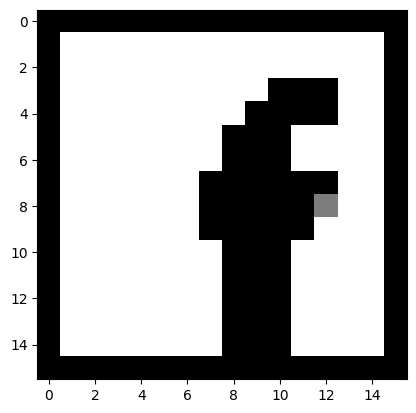

In [9]:
img = image//4
transmission_data = TransmissionData(img)
transmission_data.show_image()

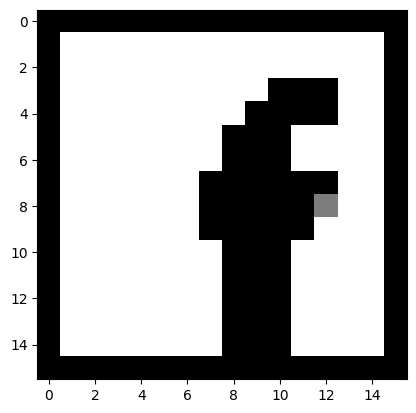

In [10]:
recieved_data = RecievedData(transmission_data.encoded_string, transmission_data.huffman_codes)
recieved_data.show_image()